```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
1. https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
2. https://pypi.org/project/rfpimp/
3. https://explained.ai/rf-importance/

```

# Feature Selection
We use feature selection to select features that are useful to the model. Irrelevant features may have a negative effect on a model. Correlated features can make coefficients in regression (or feature importance in tree models) unstable or difficult to interpret.

The `curse of dimensionality` is another issue to consider. As you increase the number of dimensions of your data, it becomes more sparse. This can make it difficult to pull out a signal unless you have more data. Neighbor calculations tend to lose their usefulness as more dimensions are added.

Also, training time is usually a function of the number of columns (and sometimes it is worse than linear). If you can be concise and precise with your columns, you can have a better model in less time.

In [1]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [2]:
from datasets import (
    get_dataset
)

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [16]:
# This is the titanic3 dataset with some extra columns for cabin information
df = get_dataset('titanic3_aggregated')

In [17]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,...,parch_mean,parch_sum,fare_min,fare_max,fare_mean,fare_sum,body_min,body_max,body_mean,body_sum
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
1,1,1,"Madill, Miss. Georgette Alexandra",female,15.0000,0,1,24160,211.3375,B5,...,0.5,1,211.3375,211.3375,211.3375,422.675,NaN,NaN,NaN,0.0
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,...,2.0,8,151.5500,151.5500,151.5500,606.200,135.0,135.0,135.0,135.0


## Collinear Columns

In [20]:
df2 = df[df.columns[:6]]
df2

,pclass,survived,name,sex,age,sibsp
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0
1,1,1,"Madill, Miss. Georgette Alexandra",female,15.0000,0
2,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1
3,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1
4,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1
...,...,...,...,...,...,...
290,3,1,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0000,0
291,3,1,"Sandstrom, Miss. Marguerite Rut",female,4.0000,1
292,3,0,"Strom, Miss. Telma Matilda",female,2.0000,0
293,3,0,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0000,1


In [22]:
limit = 0.95 # find columns that have a correlation coefficient of .95 or above

In [30]:
corr = df2.corr()
corr

,pclass,survived,age,sibsp
pclass,1.000000,-0.013737,-0.338608,-0.110235
survived,-0.013737,1.000000,-0.207643,0.147828
age,-0.338608,-0.207643,1.000000,-0.080817
sibsp,-0.110235,0.147828,-0.080817,1.000000


In [35]:
mask = np.triu(df2.corr(), k=1)
mask

array([[ 0.        , -0.01373666, -0.33860807, -0.11023461],
       [ 0.        ,  0.        , -0.20764283,  0.14782779],
       [ 0.        ,  0.        ,  0.        , -0.08081662],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [36]:
mask = np.triu(df2.corr(), k=1).astype(bool)
mask

array([[False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True],
       [False, False, False, False]])

In [37]:
corr_no_diag = corr.where(mask)
corr_no_diag

,pclass,survived,age,sibsp
pclass,NaN,-0.013737,-0.338608,-0.110235
survived,NaN,NaN,-0.207643,0.147828
age,NaN,NaN,NaN,-0.080817
sibsp,NaN,NaN,NaN,NaN


In [38]:
corr = df.corr()
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
corr_no_diag = corr.where(mask)

In [40]:
colls = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]
colls

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'body_min',
 'body_max',
 'body_mean',
 'body_sum']

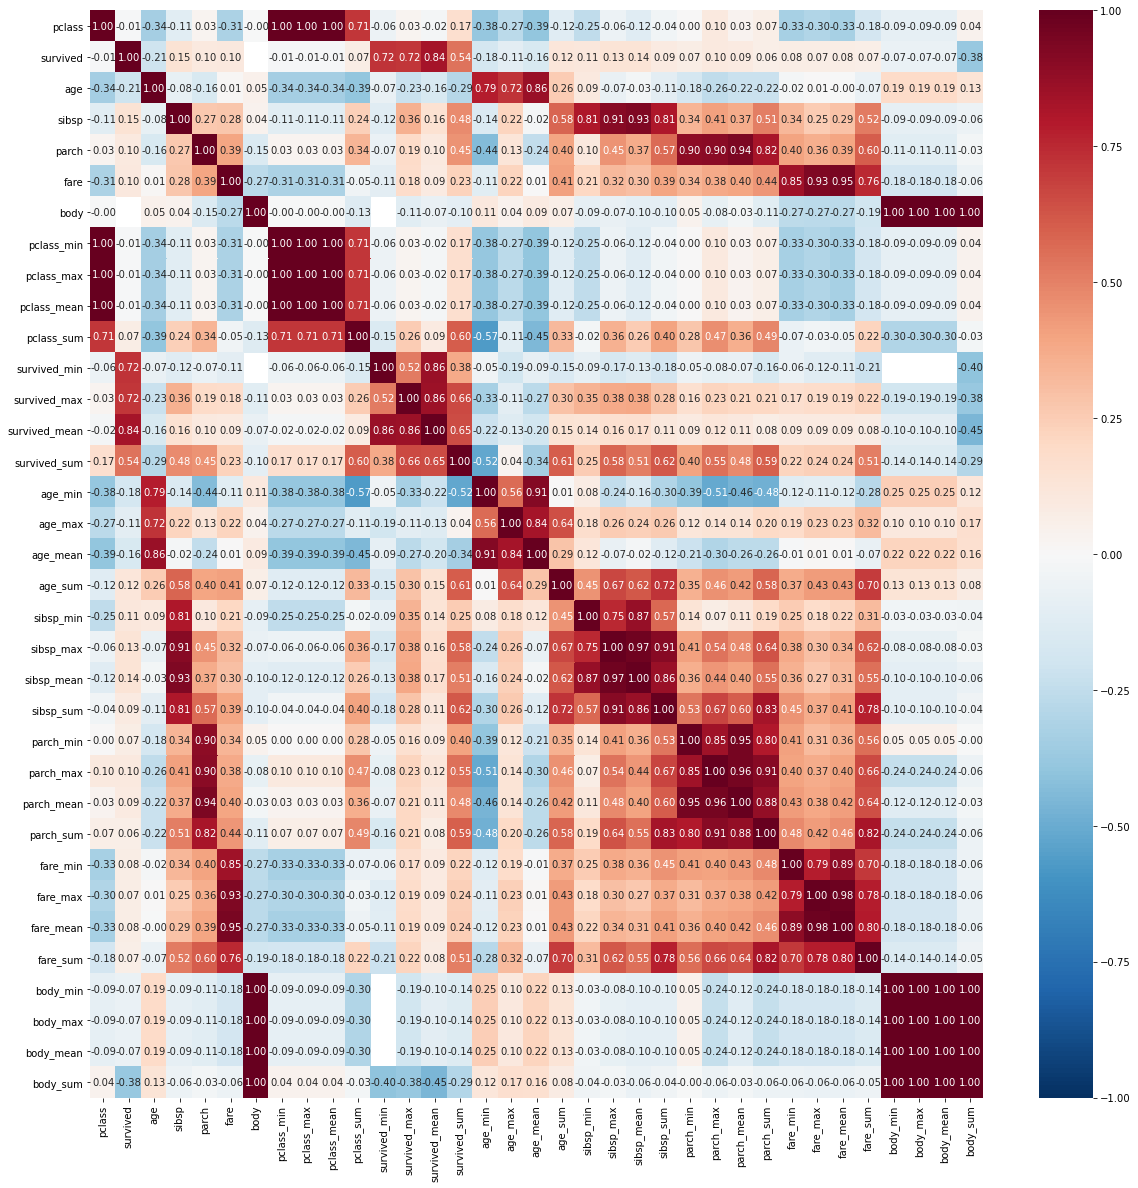

In [43]:
from seaborn import heatmap

fig, ax = plt.subplots(figsize=(20, 20))
ax = heatmap(df.corr(), fmt=".2f", annot=True, ax=ax, cmap="RdBu_r", vmin=-1, vmax=1,)
fig.savefig("images/feature_selection_correlation1.png", dpi=300)

The `rfpimp` package has a visualization of `multicollinearity`. The `plot_dependence_heatmap` function trains a random forest for each numeric column from the other columns in a training dataset. The dependence value is the R2 score from the out-of-bag (OOB) estimates for predicting that column.

The suggested way to use this plot is to find values close to 1. The label on the X axis is the feature that predicts the Y axis label. If a feature predicts another, you can remove the predicted feature (the feature on the Y axis). In our example, fare predicts pclass, sibsp, parch, and embarked_Q. We should be able to keep fare and remove the others and get similar performance.

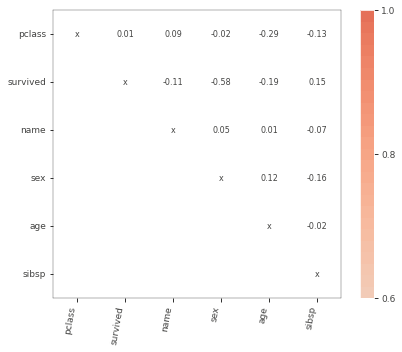

In [60]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(df2, figsize=(7,5))
viz.view()

In [66]:
cols_to_keep = ["pclass", "age"]
#dfnum = df[[c for c in df.columns if c in cols_to_keep]]
dfnum = df[cols_to_keep]
dfnum.head()

,pclass,age
0,1,29.0000
1,1,15.0000
2,1,0.9167
3,1,2.0000
4,1,30.0000


In [67]:
from rfpimp import plot_dependence_heatmap, feature_dependence_matrix

#Get numeric columns only
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#dfnum = df.select_dtypes(include=numerics)#.dropna()

plot_dependence_heatmap(feature_dependence_matrix(dfnum), 
                               value_fontsize=12,
                               label_fontsize=14,
                               figsize=(8, 8))
fig = plt.gcf()
fig.savefig("images/feature_selection_correlation2.png", dpi=300)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# Here is code showing that we get a similar score if we remove these columns
cols_to_remove = [
    "pclass",
    "sibsp",
    "parch",
    "embarked_Q",
]

rf3 = RandomForestClassifier(random_state=42)
rf3.fit(X_train[[c for c in X_train.columns if c not in cols_to_remove]], y_train,)
rf3.score(X_test[[c for c in X_train.columns if c not in cols_to_remove]], y_test,)
0.7684478371501272

rf4 = RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)
0.7659033078880407

## Lasso Regression
If you use lasso regression, you can set an `alpha` parameter that acts as a regularization parameter. As you increase the value, it gives less weight to features that are less important. Here we use the LassoLarsCV model to iterate over various values of alpha and track the feature coefficients.

In [68]:
from sklearn import linear_model

model = linear_model.LassoLarsCV(cv=10, max_n_alphas=10).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12, 8))
cm = iter(plt.get_cmap("tab20")(np.linspace(0, 1, X.shape[1])))

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i],
    )
    
ax.axvline(
    model.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)

plt.ylabel("Regression Coefficients")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title("Regression Coefficients Progression for Lasso Paths")
fig.savefig("images/feature_selection_regression_coefs.png", dpi=300)

NameError: name 'X_train' is not defined

## Recursive Feature Elimination
Recursive feature elimination will remove the weakest features, then fit a model. It does this by passing in a scikit-learn model with a `.coef_` or `.feature_importances_` attribute. We will use recursive feature elimination to find the 10 most important features.

In [ ]:
from sklearn.feature_selection import RFE

model = ensemble.RandomForestClassifier(n_estimators=100)
rfe = RFE(model, 4)
rfe.fit(X, y)
agg_X.columns[rfe.support_]

## Mutual Information
Sklearn provides nonparametric tests that will use k-nearest neighbor to determine the mutual information between features and the target. Mutual information quantifies the amount of information gained by observing another variable. The value is zero or more. If the value is zero, then there is no relation between them. This number is not bounded and represents the number of bits shared between the feature and the target.

In [ ]:
from sklearn import feature_selection

mic = feature_selection.mutual_info_classif(X, y)
fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {"feature": X.columns, "vimp": mic}
    )
    .set_index("feature")
    .plot.barh(ax=ax)
)
fig.savefig("images/feature_selection_mutual_information.png", dpi=300)

## Principal Component Analysis
Another option for feature selection is to run principal component analysis. Once you have the main principal components, examine the features that contribute to them the most. These are features that have more variance. Note that this is an unsupervised algorithm and doesn’t take y into account.

## Feature Importance
Most tree models provide access to a .feature_importances_ attribute following training. A higher importance typically means that there is higher error when the feature is removed from the model.